In [1]:
import porespy.generators as generator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import seaborn as sns
from scipy.stats import mode

In [3]:
sns.set_theme()

# functions for statistics

In [4]:

def split_arr_to_zeros_and_ones_sizes(arr):
    edge_indeces = np.argwhere(~(np.diff(arr) == 0)).flatten() +1
    segments = np.split(arr, edge_indeces)

    segments_zeros = []
    segments_ones = []

    for segment in segments:
        if np.any(segment):
            segments_ones.append(len(segment))
        else:
            segments_zeros.append(len(segment))

    return segments_zeros, segments_ones


In [5]:
def get_stats(phantom, row_numbers, axis=0):
    stat_ones, stat_zeros = [], []

    if axis == 0:
        for row_num in row_numbers:
            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)
    elif axis == 1:
        for row_num in row_numbers:
            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[:, row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)
    elif axis == "Both":
        for row_num in row_numbers:
            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)

            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[:, row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)

    stat_ones, stat_zeros = np.concatenate(stat_ones), np.concatenate(stat_zeros)

    return stat_zeros, stat_ones 


In [6]:
def compare_stats(stats, names_of_stats, num_bins=50):
    nrows = 3
    ncols = len(stats)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)

    for ax, stat, title in zip(axes[0], stats, names_of_stats):
        sns.histplot(stat, bins=num_bins, ax=ax).set_title(title+f" std: {np.std(stat):.2f}")

        mean = np.mean(stat)
        ax.axvline(mean, color='red', linewidth=3, label=f"mean: {mean:.2f}")

        mode_value = int(mode(stat)[0])
        ax.axvline(mode_value, color='purple', linewidth=2, label=f"mode: {mode_value:.2f}")
        # median = np.median(stat)
        # ax.axvline(median, color='green', linewidth=3, label=f"median: {median:.2f}")
        ax.legend()

    for ax, stat, title in zip(axes[1], stats, names_of_stats):
        sns.histplot(stat, bins=num_bins, cumulative=True, kde=True, ax=ax).set_title(f'cumulative {title}')

    for ax, stat, title in zip(axes[2], stats, names_of_stats):
        sns.histplot(stat, 
                     bins=num_bins,
                     cumulative=True,
                     kde=True,
                     stat="density",
                     ax=ax).set_title(f'cumulative density {title}')

        percetile = 90
        length_percetile = np.percentile(stat, percetile)
        ax.axhline(0.9, color='red', linewidth=3, label=f"{percetile} percetile: x={length_percetile}")
        ax.axvline(length_percetile, color='red', linewidth=3)
        ax.legend(loc=4)

    return fig

# 1 phantom

(-0.5, 999.5, 999.5, -0.5)

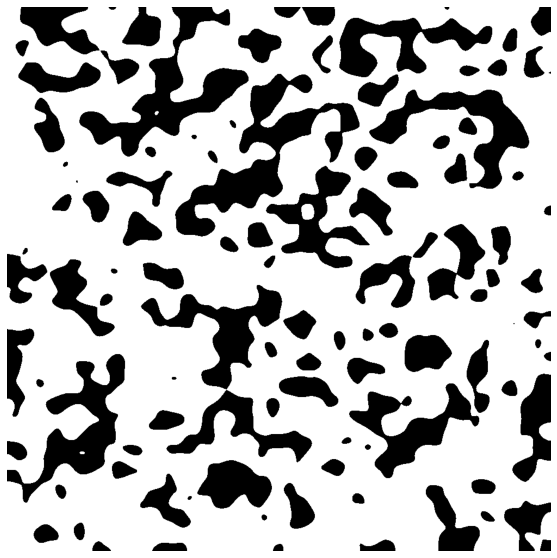

In [7]:
shape = [1000, 1000]
blobns = 2
porosity = 0.3
phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(phantom, cmap='gray')
ax.axis("off")

In [8]:
axis = 1

# few random
# N = 100
# row_numbers = [np.random.randint(phantom.shape[axis]) for _ in range(N)]

# all
row_numbers = range(phantom.shape[axis])

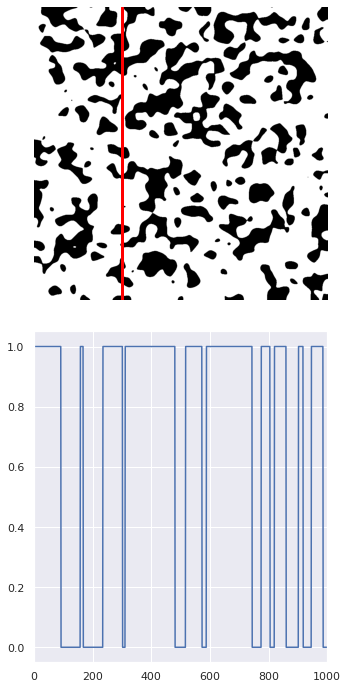

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(5,10))
num_row = 300
axes[0].imshow(phantom, cmap='gray')
axes[0].axis("off")

if axis == 0:
    axes[1].plot(phantom[num_row])
    axes[0].axhline(num_row, color='red', linewidth=3)
elif axis == 1:
    axes[1].plot(phantom[:, num_row])
    axes[0].axvline(num_row, color='red', linewidth=3)

axes[1].set_xlim(xmin=0, xmax=len(phantom[num_row]))
plt.tight_layout()

In [10]:
stat_ones, stat_zeros = get_stats(phantom, row_numbers)

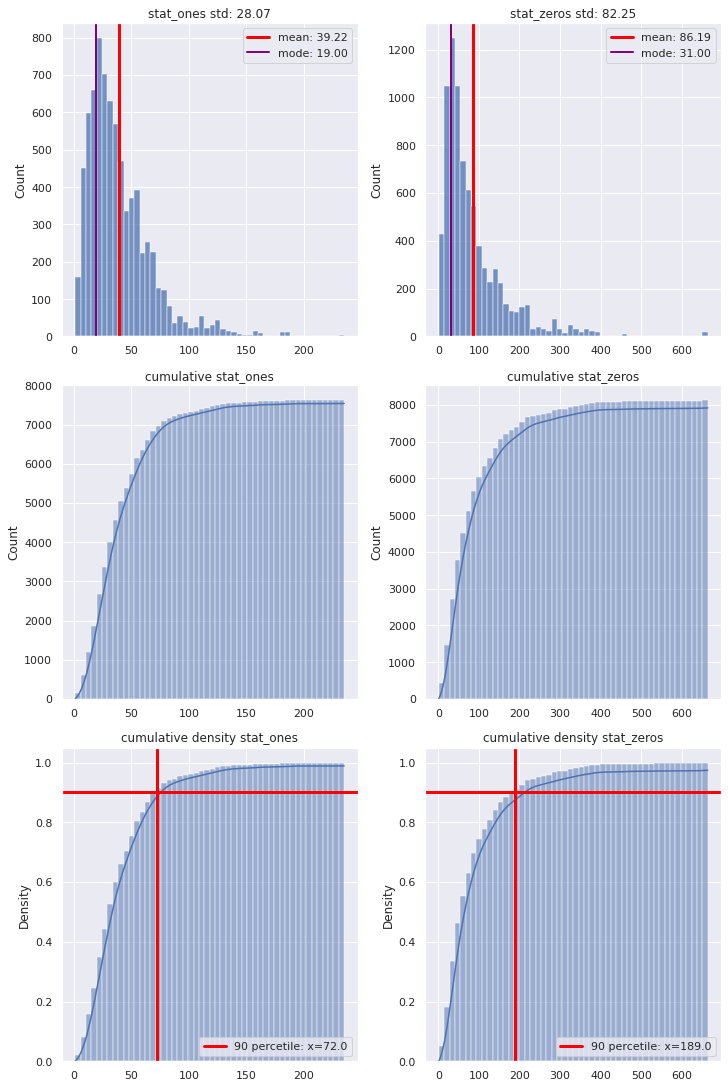

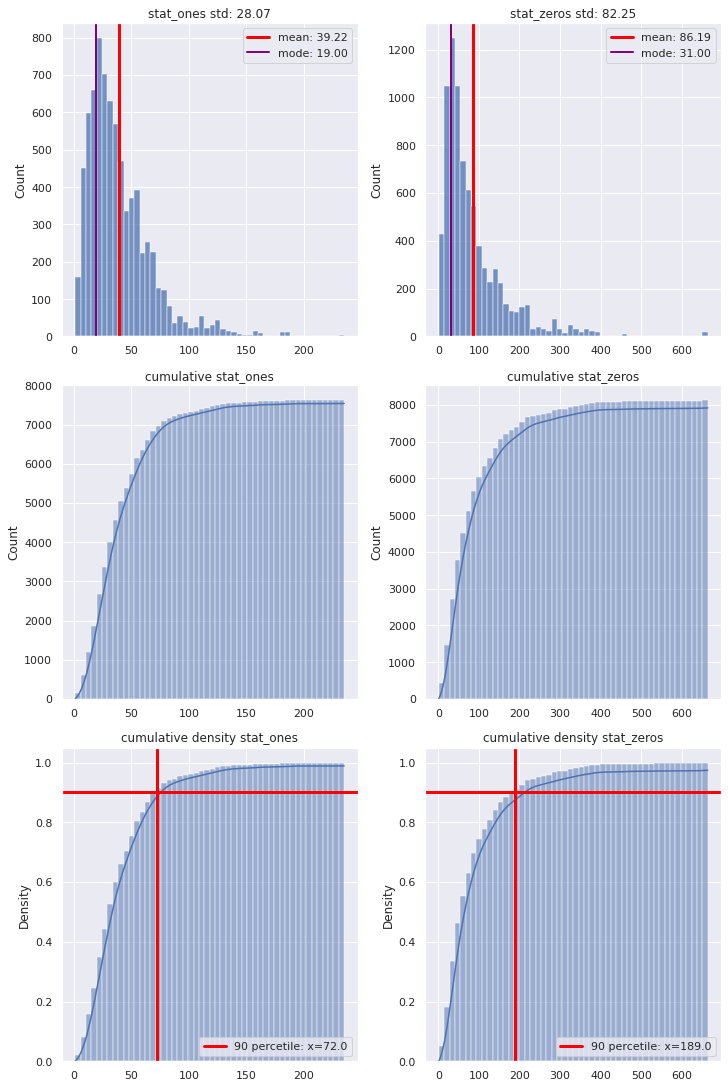

In [11]:
compare_stats(stats=[stat_ones, stat_zeros], names_of_stats=["stat_ones", "stat_zeros"], num_bins=50)

# Several phantoms

In [12]:
shape = [1000, 1000]
blobnses = [1, 3, 6]
porosity = 0.3
phantoms = [generator.blobs(shape, porosity= 1 - porosity, blobiness=b) for b in blobnses]

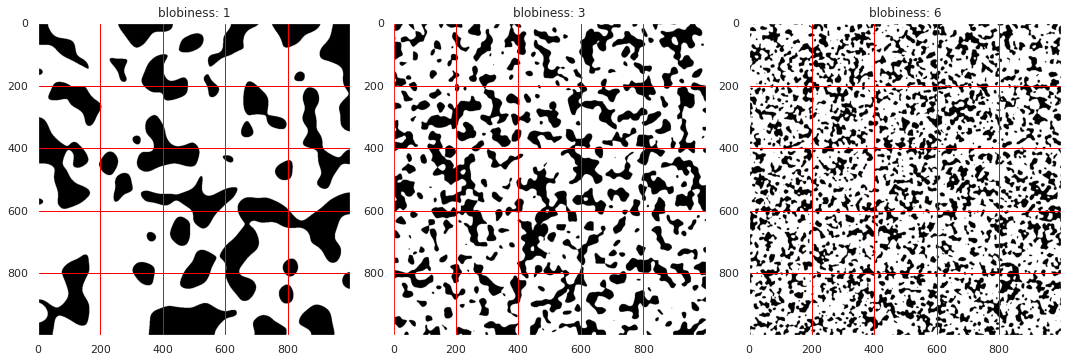

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))

for ax, blobns, phantom in zip(axes, blobnses, phantoms):
    ax.imshow(phantom, cmap='gray')
    ax.set_title(f"blobiness: {blobns}")
    ax.grid(color='red')

plt.tight_layout()

Text(0.5, 0.98, 'statistics for PORE-lengths; axis=Both')

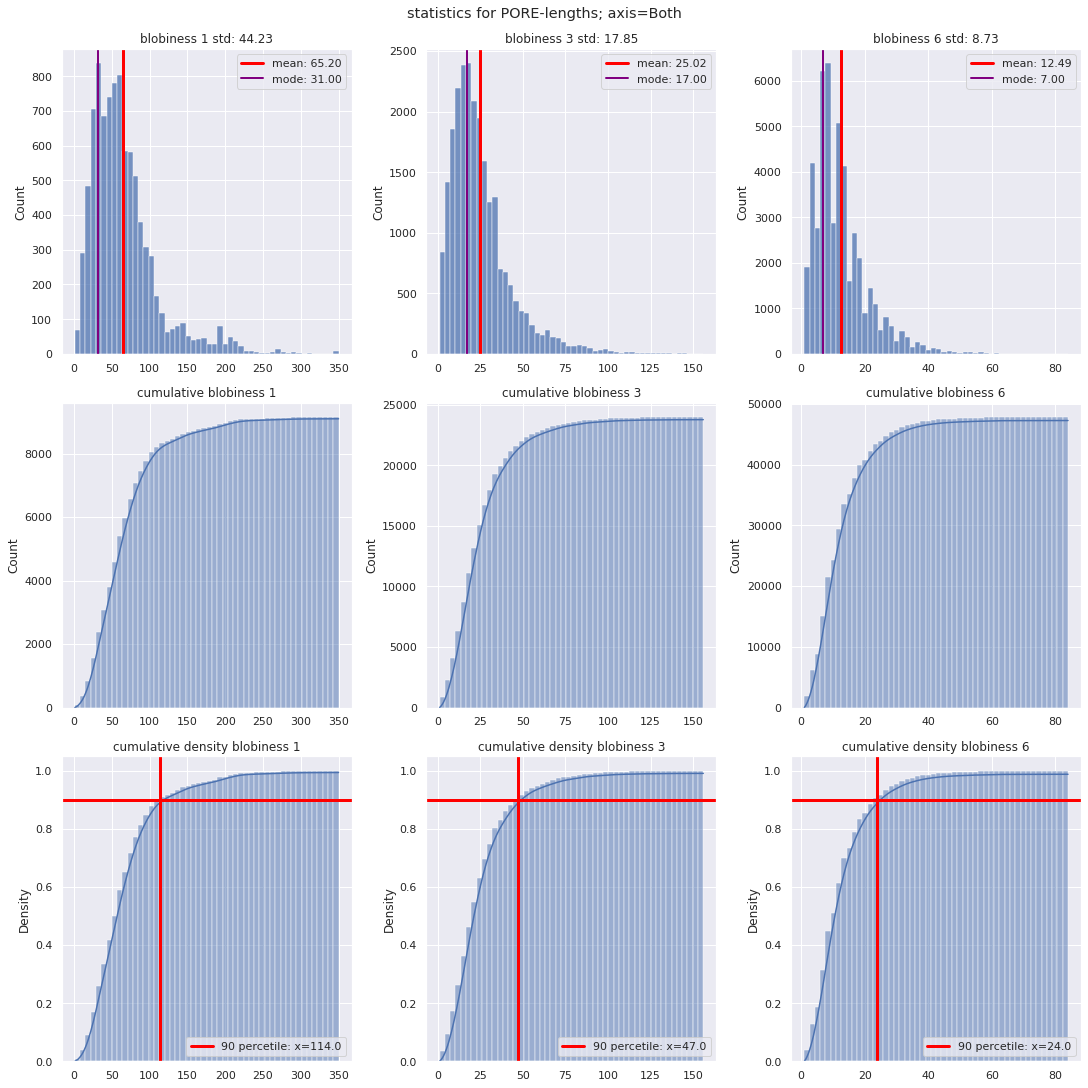

In [14]:
axis = "Both"
stats_zeros = [get_stats(phantom, row_numbers, axis=axis)[0] for phantom in phantoms]
fig = compare_stats(stats=stats_zeros, names_of_stats=[f"blobiness {b}" for b in blobnses], num_bins=50)
fig.suptitle(f"statistics for PORE-lengths; axis={axis}")


Text(0.5, 0.98, 'statistics for MATERIAL-lengths')

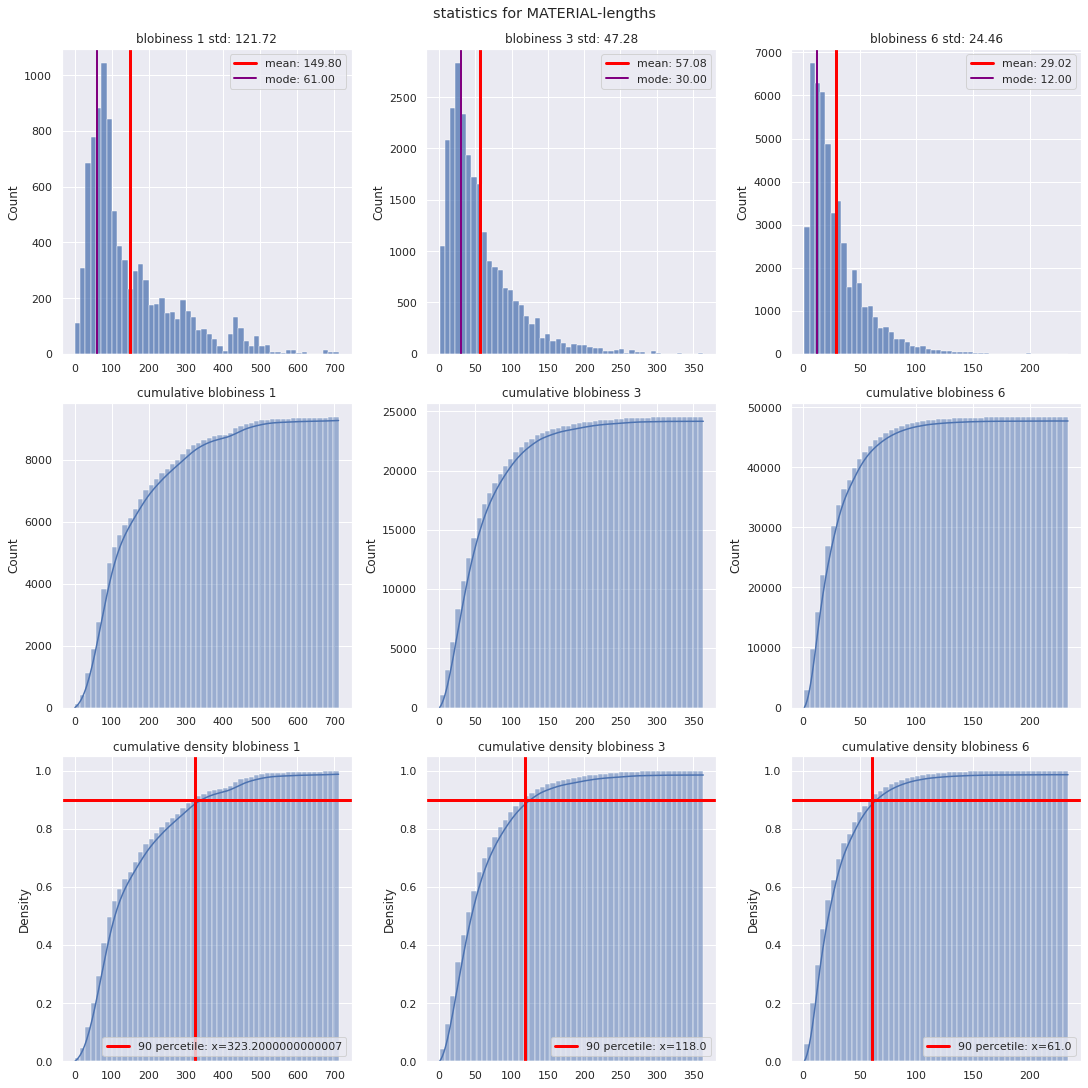

In [15]:
stats_zeros = [get_stats(phantom, row_numbers, axis=axis)[1] for phantom in phantoms]
fig = compare_stats(stats=stats_zeros, names_of_stats=[f"blobiness {b}" for b in blobnses], num_bins=50)
fig.suptitle("statistics for MATERIAL-lengths")

# Own phantoms

In [16]:
import scipy.ndimage as spim
from porespy.tools import norm_to_uniform

In [17]:
def gen_phantom(shape, porosity, blobiness):
    shape = np.array(shape)
    if np.size(shape) == 1:
        shape = np.full((3, ), int(shape))
    im = np.random.random(shape)
    im = spim.gaussian_filter(im, sigma=blobiness)
    im = norm_to_uniform(im, scale=[0, 1])
    if porosity:
        im = im < porosity
    return im

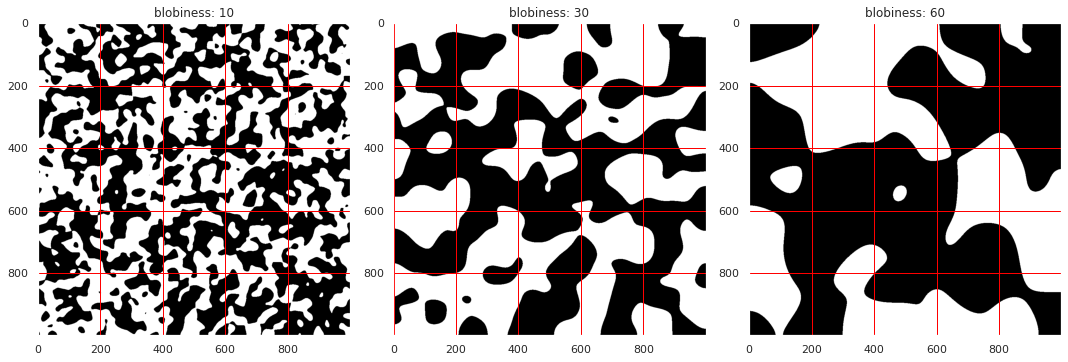

In [18]:
shape = [1000, 1000]
blobnses = [10, 30, 60]
porosity = 0.5
own_phantoms = [gen_phantom(shape, porosity= 1 - porosity, blobiness=b) for b in blobnses]

fig, axes = plt.subplots(ncols=3, figsize=(15,5))

for ax, blobns, own_phantom in zip(axes, blobnses, own_phantoms):
    ax.imshow(own_phantom, cmap='gray')
    ax.set_title(f"blobiness: {blobns}")
    ax.grid(color='red')

plt.tight_layout()

Text(0.5, 0.98, 'statistics for PORE-lengths; axis=Both')

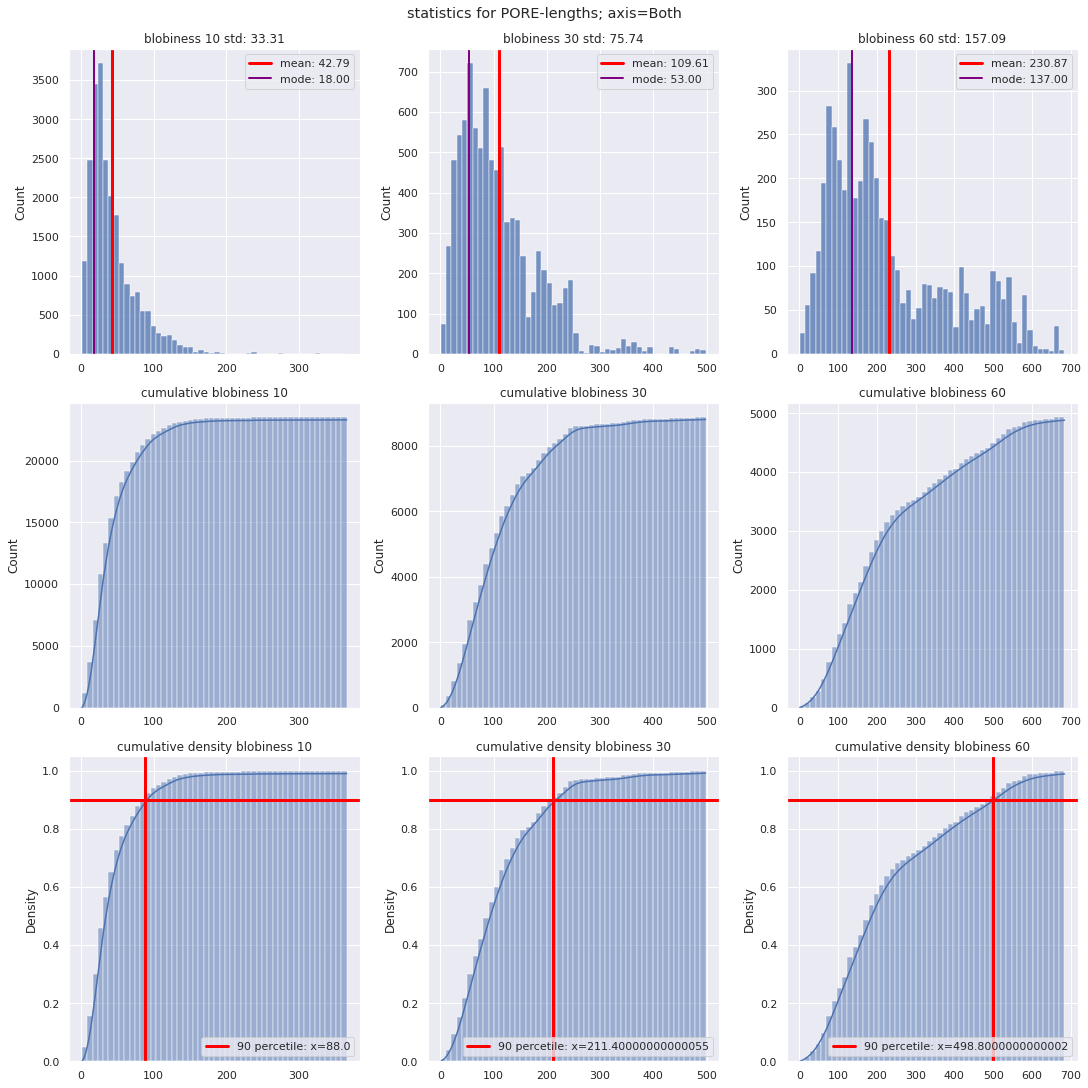

In [19]:
axis = "Both"
stats_zeros = [get_stats(own_phantom, row_numbers, axis=axis)[0] for own_phantom in own_phantoms]
fig = compare_stats(stats=stats_zeros, names_of_stats=[f"blobiness {b}" for b in blobnses], num_bins=50)
fig.suptitle(f"statistics for PORE-lengths; axis={axis}")


# Trial to find dependecies

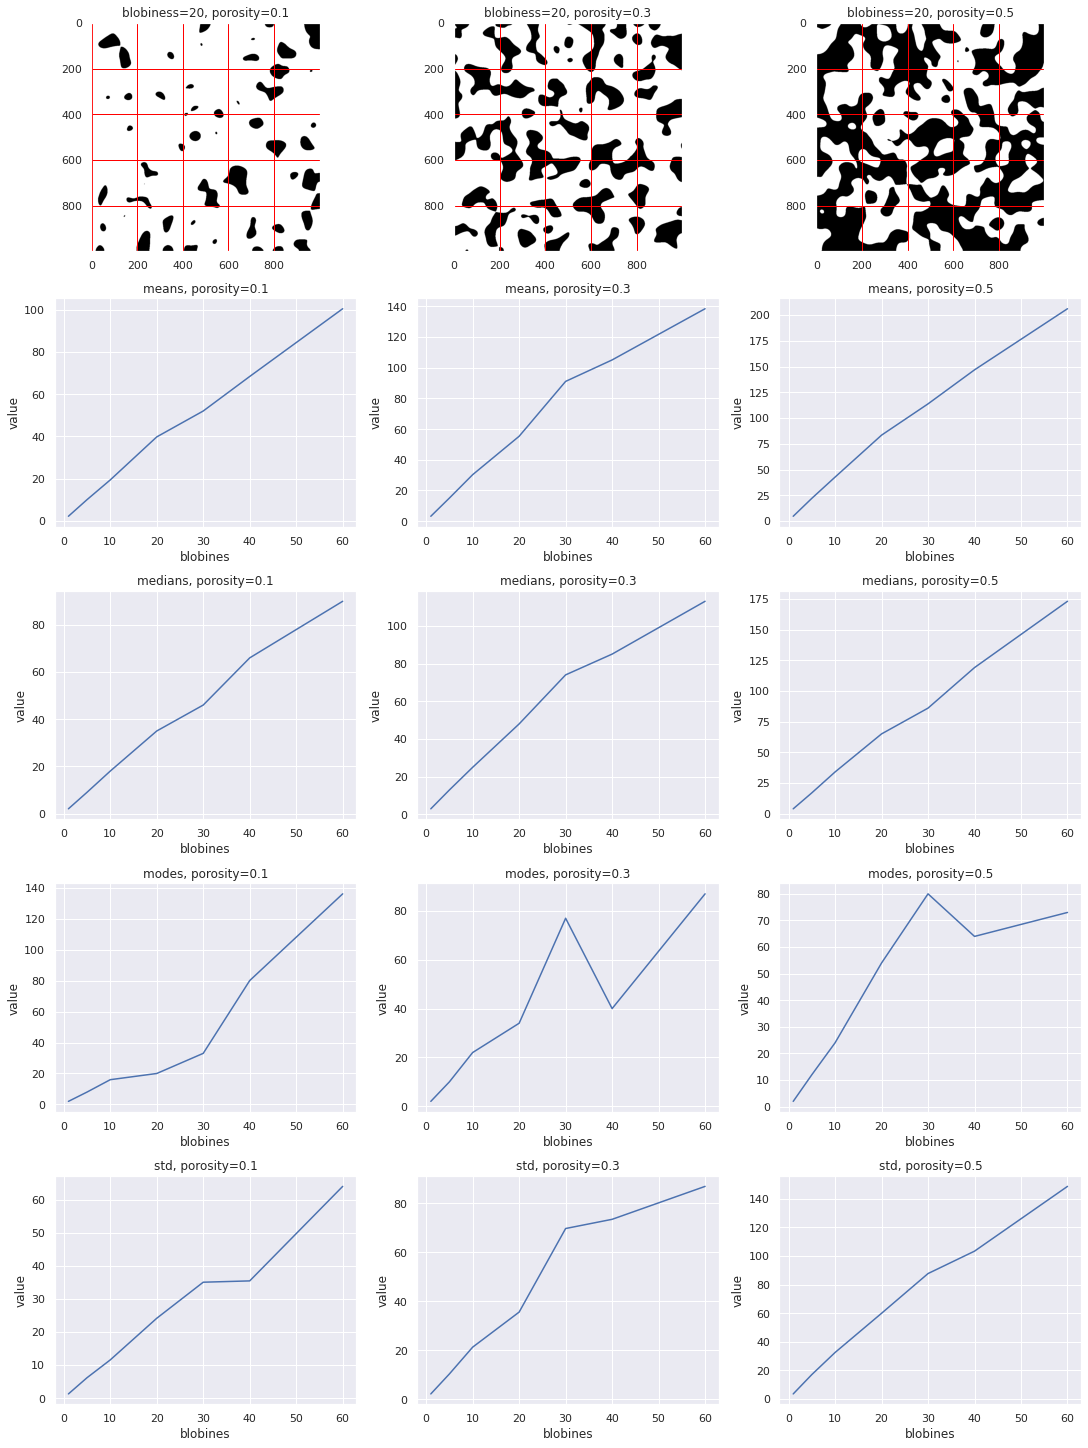

In [20]:
blobnses = [1, 5, 10, 20, 30, 40, 60]
porosities = [0.1, 0.3, 0.5]
shape = [1000, 1000]
axis = "Both"

fig, axes = plt.subplots(ncols=len(porosities), nrows=5, figsize=(15, 20), constrained_layout=True)
for ax in axes.flatten()[3:]:
    ax.set(xlabel='blobines', ylabel='value')
axes = np.transpose(axes)

for porosity, axes_col in zip(porosities, axes):
    own_phantoms = [gen_phantom(shape, porosity= 1 - porosity, blobiness=b) for b in blobnses]
    middle_index = len(blobnses)//2
    axes_col[0].imshow(own_phantoms[middle_index], cmap="gray")
    axes_col[0].set_title(f"blobiness={blobnses[middle_index]}, porosity={porosity}")
    axes_col[0].grid(color='red')

    stats_zeros = [get_stats(own_phantom, row_numbers, axis=axis)[0] for own_phantom in own_phantoms]

    means, modes, st_devs, medians= [], [], [], []
    for stat_zeros in stats_zeros:
        means.append(np.mean(stat_zeros))
        medians.append(np.median(stat_zeros))
        modes.append(int(mode(stat_zeros)[0]))
        st_devs.append(np.std(stat_zeros))

    sns.lineplot(x=blobnses, y=means, markers=True, ax=axes_col[1]).set_title(f"means, porosity={porosity}")
    sns.lineplot(x=blobnses, y=medians, markers=True, ax=axes_col[2]).set_title(f"medians, porosity={porosity}")
    sns.lineplot(x=blobnses, y=modes, markers=True, ax=axes_col[3]).set_title(f"modes, porosity={porosity}")
    sns.lineplot(x=blobnses, y=st_devs, markers=True, ax=axes_col[4]).set_title(f"std, porosity={porosity}")

In [32]:
def error_plot(x, y, y_err, ax, title):
    x, y = np.array(x), np.array(y)
    ax.plot(x, y, '-o', color='red')
    ax.fill_between(x, y - y_err, y + y_err,
                    color='blue', alpha=0.2)
    ax.set_title(title)

In [35]:
np.mean([[1,2],[1,2]], axis=1)

array([1.5, 1.5])

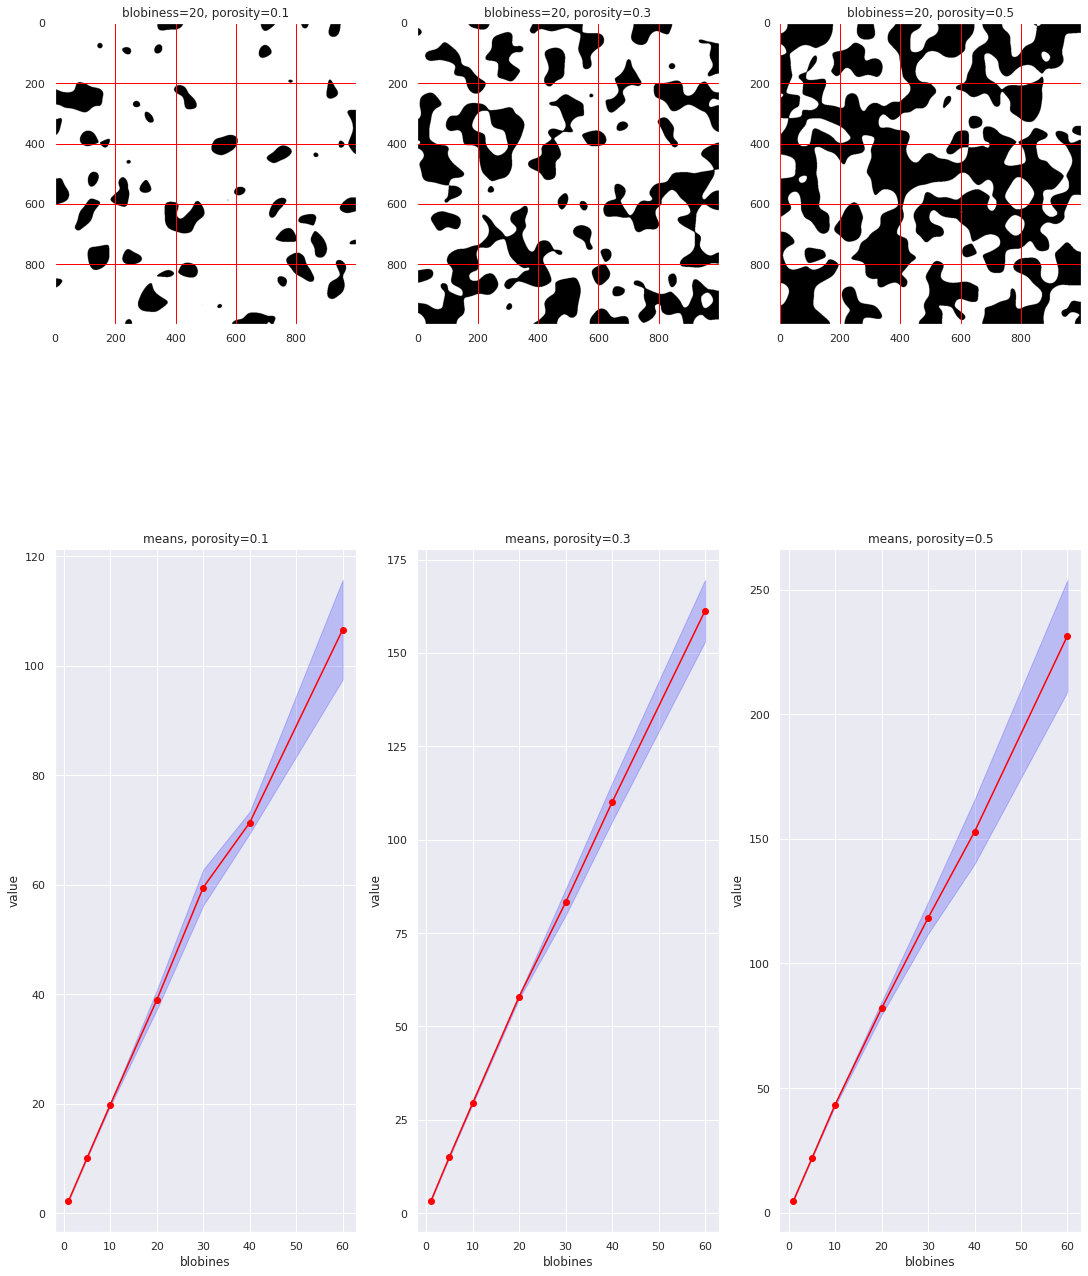

In [45]:
blobnses = [1, 5, 10, 20, 30, 40, 60]
porosities = [0.1, 0.3, 0.5]
shape = [1000, 1000]
sampling = 5
axis = "Both"

fig, axes = plt.subplots(ncols=len(porosities), nrows=2, figsize=(15, 20), constrained_layout=True)
for ax in axes.flatten()[3:]:
    ax.set(xlabel='blobines', ylabel='value')
axes = np.transpose(axes)

for porosity, axes_col in zip(porosities, axes):
    own_phantoms = [[gen_phantom(shape, porosity= 1 - porosity, blobiness=b) for _ in range(sampling)] for b in blobnses]
    middle_index = len(blobnses)//2
    axes_col[0].imshow(own_phantoms[middle_index][0], cmap="gray")
    axes_col[0].set_title(f"blobiness={blobnses[middle_index]}, porosity={porosity}")
    axes_col[0].grid(color='red')

    means_of_hists = [[np.mean(get_stats(own_phantom, row_numbers, axis=axis)[0]) for own_phantom in opr] for opr in own_phantoms]

    std_means_of_hists = [np.std(m) for m in means_of_hists]
    mean_means_of_hists = [np.mean(m) for m in means_of_hists]

    error_plot(x=blobnses, y=mean_means_of_hists, y_err=std_means_of_hists, ax=axes_col[1], title=f"means, porosity={porosity}")

In [ ]:
blobnses = [1, 5, 10, 20, 30, 40, 60]
porosities = [0.1, 0.3, 0.5]
shape = [1000, 1000]
sampling = 5
axis = "Both"

for porosity in porosities:
    for blobns in blobnses:
    own_phantoms = [[gen_phantom(shape, porosity= 1 - porosity, blobiness=b) for _ in range(sampling)] for b in blobnses]
    middle_index = len(blobnses)//2
    axes_col[0].imshow(own_phantoms[middle_index][0], cmap="gray")
    axes_col[0].set_title(f"blobiness={blobnses[middle_index]}, porosity={porosity}")
    axes_col[0].grid(color='red')

    means_of_hists = [[np.mean(get_stats(own_phantom, row_numbers, axis=axis)[0]) for own_phantom in opr] for opr in own_phantoms]

    std_means_of_hists = [np.std(m) for m in means_of_hists]
    mean_means_of_hists = [np.mean(m) for m in means_of_hists]

    error_plot(x=blobnses, y=mean_means_of_hists, y_err=std_means_of_hists, ax=axes_col[1], title=f"means, porosity={porosity}")